In [1]:
import sys
import numpy as np
import os
from os.path import abspath

import matplotlib.pyplot as plt
%matplotlib inline
import subtle.subtle_io as suio

# import subtle.subtle_preprocess as sup
import subtle.subtle_plot as suplot
import nibabel as nib
import nipype
from nipype.interfaces import fsl
import nipype.interfaces.io

from niwidgets import NiftiWidget
# NiftiWidget(_x0).nifti_plotter()

from IPython.display import Image
print(fsl.Info().version())

import SimpleITK as sitk
import subtle.subtle_preprocess as supre



Using TensorFlow backend.
/home/subtle/tensorflow/lib/python3.5/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


6.0.0


In [2]:
working_dir = '/raid/jon/data_full_stanford/data/Patient_0399'

In [3]:
nib_files = []
for filename in os.listdir(working_dir):
    if ".nii" in filename.lower():
        nib_files.append(os.path.join(working_dir,filename))
order = np.argsort([int(os.path.basename(l).split('_')[0]) for l in nib_files])
nib_files = list(np.array(nib_files)[order])
print(nib_files)

['/raid/jon/data_full_stanford/data/Patient_0399/8_ax_bravo_pre.nii.gz', '/raid/jon/data_full_stanford/data/Patient_0399/10_ax_bravo_c_pre_load_10.nii.gz', '/raid/jon/data_full_stanford/data/Patient_0399/13_ax_bravo_c.nii.gz']


In [4]:
## brain extraction
frac = .5
robust = True
reduce_bias = False

bet_zero_node = nipype.Node(fsl.BET(frac=frac, reduce_bias=reduce_bias), name='bet_zero')
bet_low_node = nipype.Node(fsl.BET(frac=frac, reduce_bias=reduce_bias), name='bet_low')
bet_full_node = nipype.Node(fsl.BET(frac=frac, reduce_bias=reduce_bias), name='bet_full')

In [5]:
## coregistration on brain extraction
cost = 'corratio'
dof = 6
searchr_x = [-20, 20]
searchr_y = [-20, 20]
searchr_z = [-20, 20]
bins = 256
interp = 'trilinear'

coreg_low_bet_node = nipype.Node(fsl.FLIRT(cost=cost, dof=dof, interp=interp, bins=bins, searchr_x=searchr_x, searchr_y=searchr_y, searchr_z=searchr_z),
                             name='coreg_bet_low')
coreg_full_bet_node = nipype.Node(fsl.FLIRT(cost=cost, dof=dof, interp=interp, bins=bins, searchr_x=searchr_x, searchr_y=searchr_y, searchr_z=searchr_z),
                             name='coreg_bet_full')



In [6]:
## coregistration on full images using result from brain extraction
coreg_low_node = nipype.Node(fsl.FLIRT(apply_xfm=True, cost=cost, dof=dof, interp=interp, bins=bins, searchr_x=searchr_x, searchr_y=searchr_y, searchr_z=searchr_z),
                             name='coreg_low')
coreg_full_node = nipype.Node(fsl.FLIRT(apply_xfm=True, cost=cost, dof=dof, interp=interp, bins=bins, searchr_x=searchr_x, searchr_y=searchr_y, searchr_z=searchr_z),
                             name='coreg_full')



In [7]:
from nipype.interfaces.base import BaseInterface, \
    BaseInterfaceInputSpec, traits, File, TraitedSpec
from nipype.utils.filemanip import split_filename

import nibabel as nb
import numpy as np
import os

class SimpleThresholdInputSpec(BaseInterfaceInputSpec):
    volume = File(exists=True, desc='volume to be thresholded', mandatory=True)
    threshold = traits.Float(desc='everything below this value will be set to zero',
                             mandatory=True)


class SimpleThresholdOutputSpec(TraitedSpec):
    thresholded_volume = File(exists=True, desc="thresholded volume")


class SimpleThreshold(BaseInterface):
    input_spec = SimpleThresholdInputSpec
    output_spec = SimpleThresholdOutputSpec

    def _run_interface(self, runtime):
        fname = self.inputs.volume
        img = nb.load(fname)
        data = np.array(img.get_data())

        active_map = data > self.inputs.threshold

        thresholded_map = np.zeros(data.shape)
        thresholded_map[active_map] = data[active_map]

        new_img = nb.Nifti1Image(thresholded_map, img.affine, img.header)
        _, base, _ = split_filename(fname)
        nb.save(new_img, base + '_thresholded.nii.gz')

        return runtime

    def _list_outputs(self):
        outputs = self._outputs().get()
        fname = self.inputs.volume
        _, base, _ = split_filename(fname)
        outputs["thresholded_volume"] = os.path.abspath(base + '_thresholded.nii.gz')
        return outputs

In [8]:
from nipype.interfaces.base import BaseInterface, \
    BaseInterfaceInputSpec, traits, File, TraitedSpec
from nipype.utils.filemanip import split_filename

import nibabel as nb
import numpy as np
import os

class MaskIntersectInputSpec(BaseInterfaceInputSpec):
    in0 = File(exists=True, desc='input 0', mandatory=True)
    in1 = File(exists=True, desc='input 1', mandatory=True)
    in2 = File(exists=True, desc='input 2', mandatory=True)



class MaskIntersectOutputSpec(TraitedSpec):
    out = File(exists=True, desc="mask")


class MaskIntersect(BaseInterface):
    input_spec = MaskIntersectInputSpec
    output_spec = MaskIntersectOutputSpec

    def _run_interface(self, runtime):
        f0 = self.inputs.in0
        f1 = self.inputs.in1
        f2 = self.inputs.in2
        
        x0 = nb.load(f0)
        x1 = nb.load(f1)
        x2 = nb.load(f2)
        
        mask = ((x0.get_fdata()>0) & (x1.get_fdata()>0) & (x2.get_fdata()>0))

        out = nb.Nifti1Image(mask, x0.affine, x0.header)
        _, base, _ = split_filename(f0)
        nb.save(out, base + '_combined_mask.nii.gz')

        return runtime

    def _list_outputs(self):
        outputs = self._outputs().get()
        fname = self.inputs.in0
        _, base, _ = split_filename(fname)
        outputs["out"] = os.path.abspath(base + '_combined_mask.nii.gz')
        return outputs

In [9]:
from nipype.interfaces.base import BaseInterface, \
    BaseInterfaceInputSpec, traits, File, TraitedSpec
from nipype.utils.filemanip import split_filename

import nibabel as nb
import numpy as np
import os

class MaskUnionInputSpec(BaseInterfaceInputSpec):
    in0 = File(exists=True, desc='input 0', mandatory=True)
    in1 = File(exists=True, desc='input 1', mandatory=True)
    in2 = File(exists=True, desc='input 2', mandatory=True)



class MaskUnionOutputSpec(TraitedSpec):
    out = File(exists=True, desc="mask")


class MaskUnion(BaseInterface):
    input_spec = MaskUnionInputSpec
    output_spec = MaskUnionOutputSpec

    def _run_interface(self, runtime):
        f0 = self.inputs.in0
        f1 = self.inputs.in1
        f2 = self.inputs.in2
        
        x0 = nb.load(f0)
        x1 = nb.load(f1)
        x2 = nb.load(f2)
        
        mask = ((x0.get_fdata()>0) | (x1.get_fdata()>0) | (x2.get_fdata()>0))

        out = nb.Nifti1Image(mask, x0.affine, x0.header)
        _, base, _ = split_filename(f0)
        nb.save(out, base + '_combined_mask.nii.gz')

        return runtime

    def _list_outputs(self):
        outputs = self._outputs().get()
        fname = self.inputs.in0
        _, base, _ = split_filename(fname)
        outputs["out"] = os.path.abspath(base + '_combined_mask.nii.gz')
        return outputs

In [10]:
from nipype.interfaces.base import BaseInterface, \
    BaseInterfaceInputSpec, traits, File, TraitedSpec
from nipype.utils.filemanip import split_filename

import nibabel as nb
import numpy as np
import os

class ApplyMaskInputSpec(BaseInterfaceInputSpec):
    input_file = File(exists=True, desc='input', mandatory=True)
    mask = File(exists=True, desc='mask', mandatory=True)



class ApplyMaskOutputSpec(TraitedSpec):
    out = File(exists=True, desc="masked image")


class ApplyMask(BaseInterface):
    input_spec = ApplyMaskInputSpec
    output_spec = ApplyMaskOutputSpec

    def _run_interface(self, runtime):
        f0 = self.inputs.input_file
        fm = self.inputs.mask
        
        x0 = nb.load(f0)
        xm = nb.load(fm)
        
        x_out = x0.get_fdata() * xm.get_fdata()
        
        out = nb.Nifti1Image(x_out, x0.affine, x0.header)
        _, base, _ = split_filename(f0)
        nb.save(out, base + '_masked.nii.gz')

        return runtime

    def _list_outputs(self):
        outputs = self._outputs().get()
        fname = self.inputs.input_file
        _, base, _ = split_filename(fname)
        outputs["out"] = os.path.abspath(base + '_masked.nii.gz')
        return outputs

In [11]:
mask_combine_node = nipype.Node(MaskUnion(), name='mask_combine')
masked_zero_node = nipype.Node(ApplyMask(), name='masked_zero')
masked_low_node = nipype.Node(ApplyMask(), name='masked_low')
masked_full_node = nipype.Node(ApplyMask(), name='masked_full')

190416-16:29:45,780 nipype.workflow INFO:
	 Generated workflow graph: /raid/jon/data_full_stanford/data/Patient_0399/preprocess/graph.png (graph2use=flat, simple_form=True).


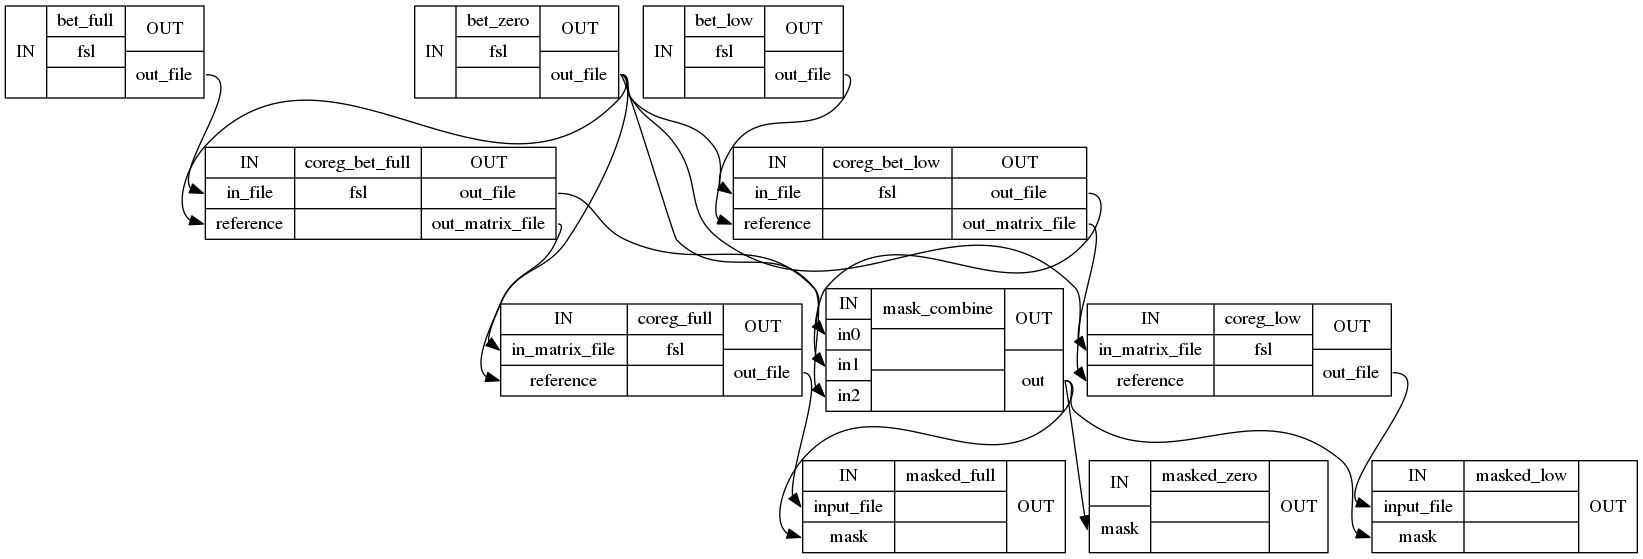

In [12]:
wf = nipype.Workflow(name='preprocess', base_dir=working_dir)
wf.connect([
    (bet_zero_node, coreg_low_bet_node, [('out_file', 'reference')]), 
    (bet_low_node, coreg_low_bet_node, [('out_file', 'in_file')]), 
    
    (bet_zero_node, coreg_full_bet_node, [('out_file', 'reference')]), 
    (bet_full_node, coreg_full_bet_node, [('out_file', 'in_file')]), 
    
    (coreg_full_bet_node, coreg_full_node, [('out_matrix_file', 'in_matrix_file')]), 
    (bet_zero_node, coreg_full_node, [('out_file', 'reference')]), # dummy file
    
    (coreg_low_bet_node, coreg_low_node, [('out_matrix_file', 'in_matrix_file')]), 
    (bet_zero_node, coreg_low_node, [('out_file', 'reference')]), # dummy file
    
    (coreg_full_bet_node, mask_combine_node, [('out_file', 'in0')]), 
    (coreg_low_bet_node, mask_combine_node, [('out_file', 'in1')]), 
    (bet_zero_node, mask_combine_node, [('out_file', 'in2')]), 
     
    (mask_combine_node, masked_zero_node, [('out', 'mask')]), 
    (mask_combine_node, masked_low_node, [('out', 'mask')]), 
    (mask_combine_node, masked_full_node, [('out', 'mask')]), 
    
#     (bet_zero_node, masked_zero_node, [('out_file', 'input_file')]), 
    (coreg_low_node, masked_low_node, [('out_file', 'input_file')]), 
    (coreg_full_node, masked_full_node, [('out_file', 'input_file')]), 

           ])

# wf.write_graph('workflow_graph.dot')
# Image(filename='{working_dir}/preprocess/workflow_graph.png'.format(working_dir=working_dir))

wf.write_graph(graph2use='flat')
Image(filename='{working_dir}/preprocess/graph_detailed.png'.format(working_dir=working_dir))

In [13]:
bet_zero_node.inputs.in_file = nib_files[0]
bet_low_node.inputs.in_file = nib_files[1]
bet_full_node.inputs.in_file = nib_files[2]
masked_zero_node.inputs.input_file = nib_files[0]
coreg_low_node.inputs.in_file = nib_files[1]
coreg_full_node.inputs.in_file = nib_files[2]

# wf.run()
wf.run(plugin='MultiProc', plugin_args={'n_procs' : 8})

190416-16:29:58,672 nipype.workflow INFO:
	 Workflow preprocess settings: ['check', 'execution', 'logging', 'monitoring']
190416-16:29:58,706 nipype.workflow INFO:
	 Running in parallel.
190416-16:29:58,718 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 3 jobs ready. Free memory (GB): 226.65/226.65, Free processors: 8/8.
190416-16:29:58,976 nipype.workflow INFO:
	 [Node] Setting-up "preprocess.bet_low" in "/raid/jon/data_full_stanford/data/Patient_0399/preprocess/bet_low".190416-16:29:58,983 nipype.workflow INFO:
	 [Node] Setting-up "preprocess.bet_full" in "/raid/jon/data_full_stanford/data/Patient_0399/preprocess/bet_full".

190416-16:29:58,985 nipype.workflow INFO:
	 [Node] Setting-up "preprocess.bet_zero" in "/raid/jon/data_full_stanford/data/Patient_0399/preprocess/bet_zero".
190416-16:29:59,4 nipype.workflow INFO:
	 [Node] Running "bet_full" ("nipype.interfaces.fsl.preprocess.BET"), a CommandLine Interface with command:
bet /raid/jon/data_full_stanford/data/Patient_0399

190416-16:37:57,361 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 1 jobs ready. Free memory (GB): 226.25/226.65, Free processors: 6/8.
                     Currently running:
                       * preprocess.coreg_full
                       * preprocess.coreg_low
190416-16:37:57,539 nipype.workflow INFO:
	 [Node] Setting-up "preprocess.masked_zero" in "/raid/jon/data_full_stanford/data/Patient_0399/preprocess/masked_zero".
190416-16:37:57,549 nipype.workflow INFO:
	 [Node] Running "masked_zero" ("__main__.ApplyMask")
190416-16:37:59,204 nipype.workflow INFO:
	 [Node] Finished "preprocess.coreg_low".
190416-16:37:59,351 nipype.workflow INFO:
	 [Job 6] Completed (preprocess.coreg_low).
190416-16:37:59,355 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 1 jobs ready. Free memory (GB): 226.25/226.65, Free processors: 6/8.
                     Currently running:
                       * preprocess.masked_zero
                       * preprocess.coreg_full
190416-16:3

In [14]:
print(working_dir)
!tree /raid/jon/data_full_stanford/data/Patient_0399/preprocess -I '*js|*json|*html|*pklz|_report'


/raid/jon/data_full_stanford/data/Patient_0399
/raid/jon/data_full_stanford/data/Patient_0399/preprocess
├── bet_full
│   ├── 13_ax_bravo_c_brain.nii.gz
│   └── command.txt
├── bet_low
│   ├── 10_ax_bravo_c_pre_load_10_brain.nii.gz
│   └── command.txt
├── bet_zero
│   ├── 8_ax_bravo_pre_brain.nii.gz
│   └── command.txt
├── coreg_bet_full
│   ├── 13_ax_bravo_c_brain_flirt.mat
│   ├── 13_ax_bravo_c_brain_flirt.nii.gz
│   └── command.txt
├── coreg_bet_low
│   ├── 10_ax_bravo_c_pre_load_10_brain_flirt.mat
│   ├── 10_ax_bravo_c_pre_load_10_brain_flirt.nii.gz
│   └── command.txt
├── coreg_full
│   ├── 13_ax_bravo_c_flirt.nii.gz
│   └── command.txt
├── coreg_low
│   ├── 10_ax_bravo_c_pre_load_10_flirt.nii.gz
│   └── command.txt
├── graph_detailed.dot
├── graph_detailed.png
├── graph.dot
├── graph.png
├── mask_combine
│   └── 13_ax_bravo_c_brain_flirt_combined_mask.nii.gz
├── masked_full
│   └── 13_ax_bravo_c_flirt_masked.nii.gz
├── masked_low
│   └── 10_ax_bravo_c_pre_load_10_flirt_masked.nii

(512, 512, 312)


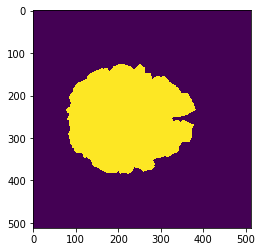

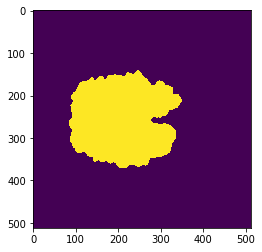

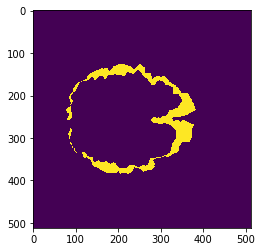

In [15]:
idx = 200
_tmp = nib.load('{}/preprocess/masked_full/13_ax_bravo_c_flirt_masked.nii.gz'.format(working_dir))
_tmp2 = nib.load('{}/preprocess/coreg_bet_full/13_ax_bravo_c_brain_flirt.nii.gz'.format(working_dir))
tmp2 = _tmp2.get_fdata()
tmp = _tmp.get_fdata()
print(tmp.shape)
plt.imshow(tmp[...,idx]>0)
plt.figure()
plt.imshow(tmp2[...,idx]>0)
plt.figure()
plt.imshow(((tmp>0)!=(tmp2>0))[...,idx])


In [16]:
_x0b = nib.load('{}/preprocess/masked_zero/8_ax_bravo_pre_masked.nii.gz'.format(working_dir))
_x1b = nib.load('{}/preprocess/masked_low/10_ax_bravo_c_pre_load_10_flirt_masked.nii.gz'.format(working_dir))
_x2b = nib.load('{}/preprocess/masked_full/13_ax_bravo_c_flirt_masked.nii.gz'.format(working_dir))
x0b, x1b, x2b = [__x.get_fdata() for __x in (_x0b, _x1b, _x2b)]

_x0 = nib.load(nib_files[0])
_x1 = nib.load('{}/preprocess/coreg_low/10_ax_bravo_c_pre_load_10_flirt.nii.gz'.format(working_dir))
_x2 = nib.load('{}/preprocess/coreg_full/13_ax_bravo_c_flirt.nii.gz'.format(working_dir))
x0, x1, x2 = [__x.get_fdata() for __x in (_x0, _x1, _x2)]


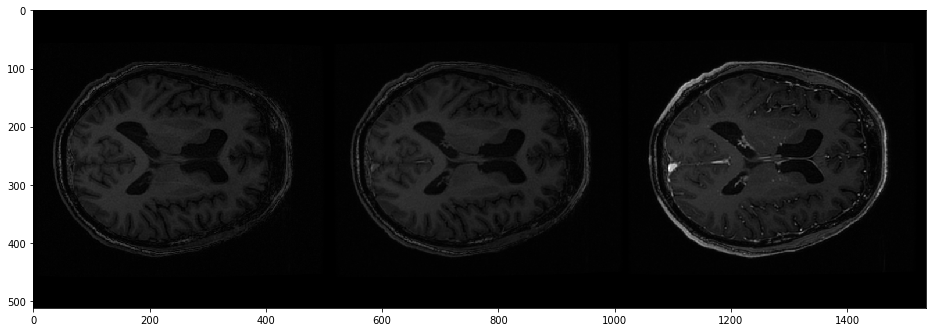

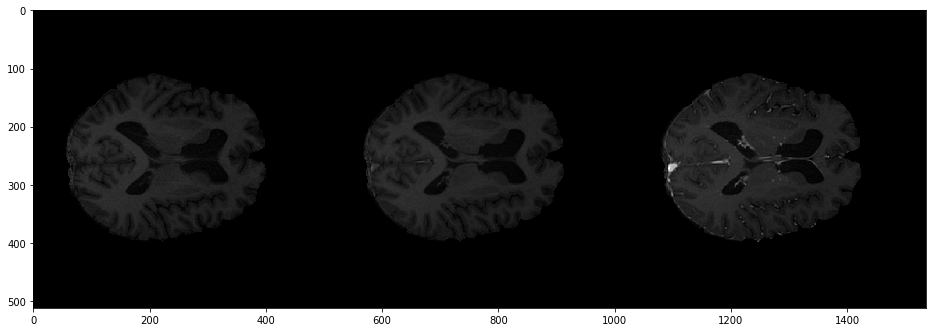

In [17]:
idx = 150

plt.figure(figsize=(16,10))
suplot.imshowtile(np.stack((x0,x1,x2), axis=3)[:,:,idx,:].squeeze())

plt.figure(figsize=(16,10))
suplot.imshowtile(np.stack((x0b,x1b,x2b), axis=3)[:,:,idx,:].squeeze())


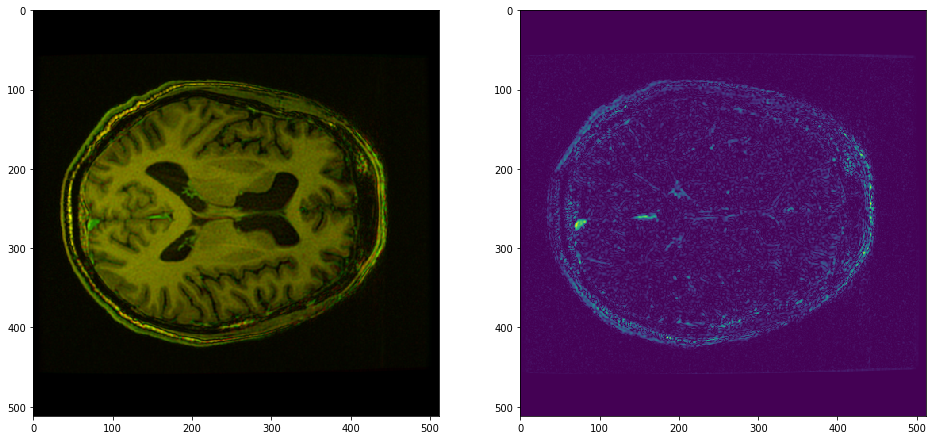

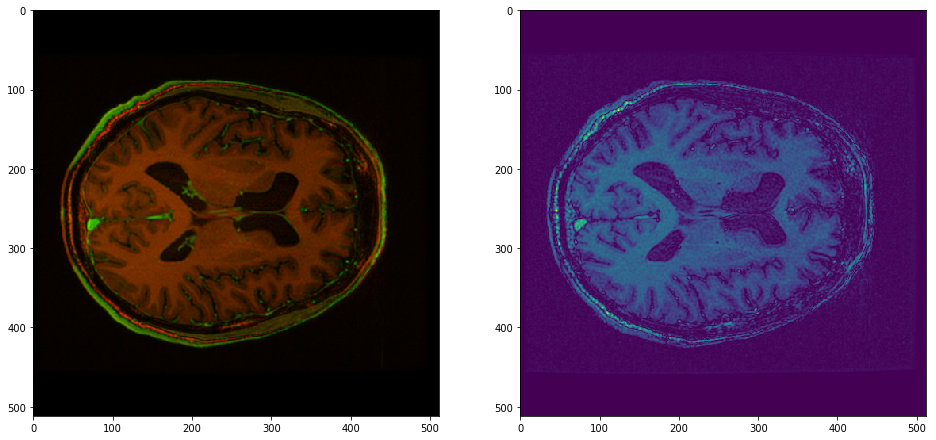

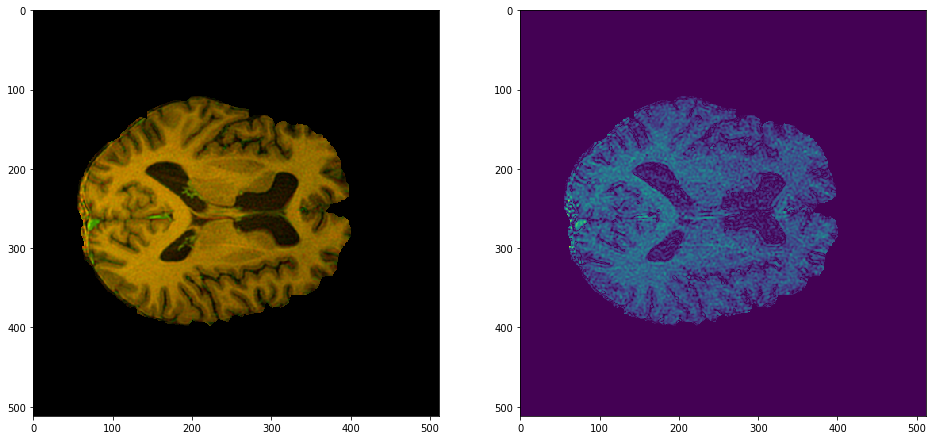

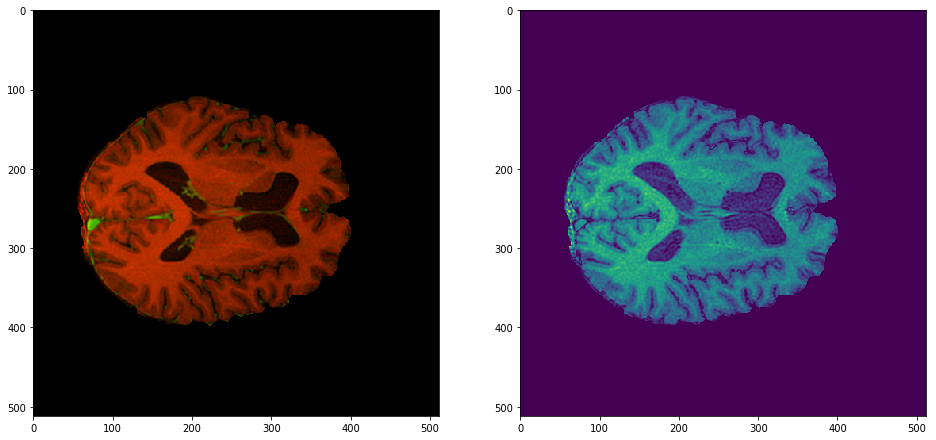

In [18]:
plt.figure(figsize=(16,10))
suplot.imshowreg(x0[...,idx], x1[...,idx])

plt.figure(figsize=(16,10))
suplot.imshowreg(x0[...,idx], x2[...,idx])

plt.figure(figsize=(16,10))
suplot.imshowreg(x0b[...,idx], x1b[...,idx])

plt.figure(figsize=(16,10))
suplot.imshowreg(x0b[...,idx], x2b[...,idx])


## test kmeans to make enhancement mask 

In [19]:
from sklearn.cluster import KMeans

In [20]:
n = 6
idx_kmeans = np.arange(idx-20, idx+20)
X = np.stack((x0[...,idx_kmeans].ravel(), x1[...,idx_kmeans].ravel(), x2[...,idx_kmeans].ravel())).T
Xn = np.linalg.norm(X, axis=1)
print(X.shape)
X2 = X[Xn > 0.05*np.max(Xn)]
print(X2.shape)
kmeans = KMeans(n_clusters=n, random_state=723, n_jobs=10)
kmeans.fit(X2)

(10485760, 3)
(4054029, 3)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=10, precompute_distances='auto',
    random_state=723, tol=0.0001, verbose=0)

In [21]:
Y = kmeans.predict(X).reshape((x0[...,idx_kmeans].shape)).squeeze()
print(Y.shape)

(512, 512, 40)


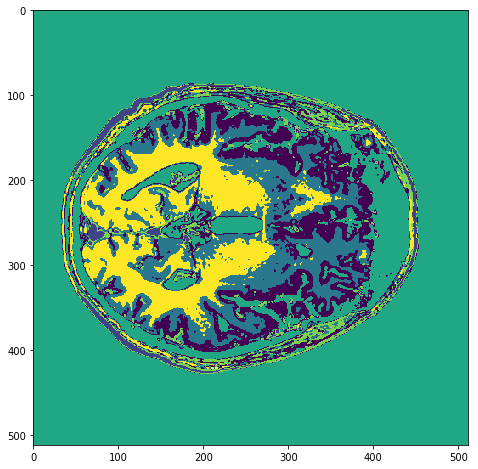

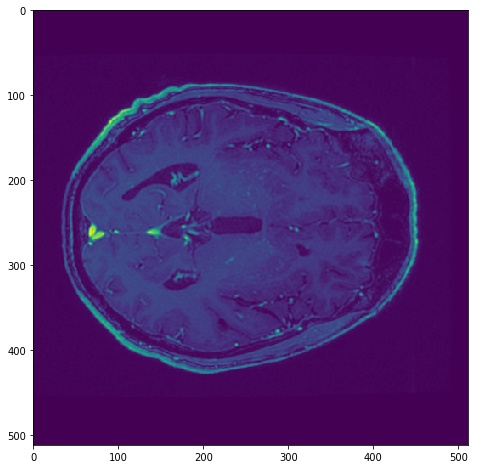

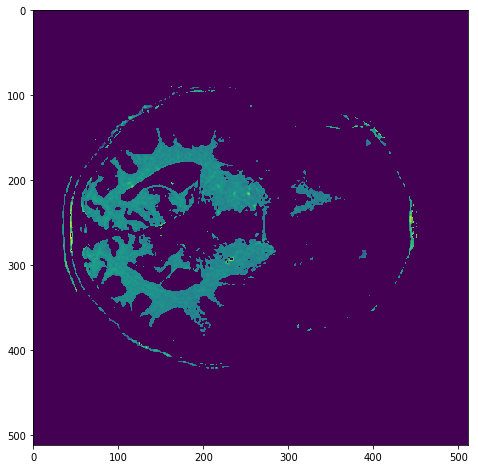

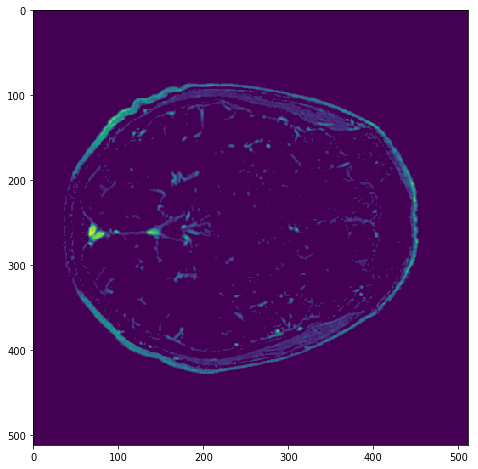

In [22]:
_idx = 0
plt.figure(figsize=(8,8))
plt.imshow(Y[...,_idx])
plt.figure(figsize=(8,8))
plt.imshow(x2[...,idx_kmeans[_idx]].squeeze())
plt.figure(figsize=(8,8))
plt.imshow(x2[...,idx_kmeans[_idx]].squeeze() * (Y[...,_idx]==5))

# it seems like it's simpler to threshold the difference image to get an enhancement mask
tmp = x2-x0
plt.figure(figsize=(8,8))
plt.imshow((tmp*(tmp > .05*np.max(abs(tmp))))[...,idx_kmeans[_idx]].squeeze())

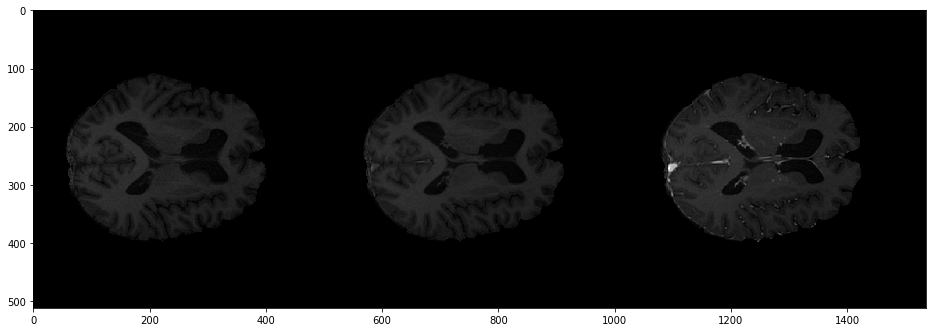

In [23]:
idx=150
plt.figure(figsize=(16,8))
suplot.imshowtile(np.stack((x0,x1,x2), axis=3)[:,:,idx,:].squeeze())
suplot.imshowtile(np.stack((x0b,x1b,x2b), axis=3)[:,:,idx,:].squeeze())

0.8510558038459961
0.9851326417647299


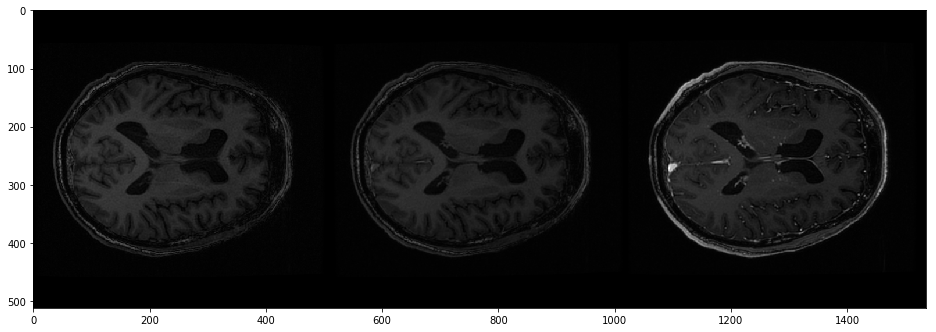

In [27]:
x2_sc = supre.scale_im_enhao(x0[...,idx-5:idx+5], x2[...,idx-5:idx+5], max_iter=3)
print(x2_sc)
x2_scaled = x2 * x2_sc

x1_sc = supre.scale_im_enhao(x0[...,idx-5:idx+5], x1[...,idx-5:idx+5], max_iter=3)
print(x1_sc)
x1_scaled = x1 * x2_sc

plt.figure(figsize=(16,8))
suplot.imshowtile(np.stack((x0,x1_scaled,x2_scaled), axis=3)[:,:,idx,:].squeeze())


0.910246422567551
0.9978432900077904


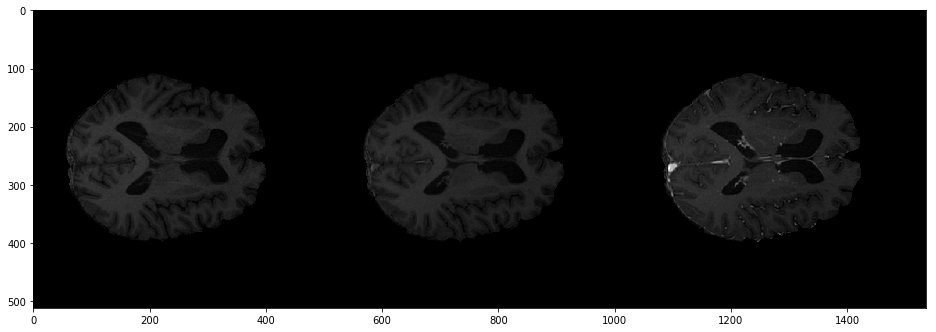

In [28]:
x2_sc = supre.scale_im_enhao(x0b[...,idx-5:idx+5], x2b[...,idx-5:idx+5], max_iter=3)
print(x2_sc)
x2b_scaled = x2b * x2_sc

x1_sc = supre.scale_im_enhao(x0b[...,idx-5:idx+5], x1b[...,idx-5:idx+5], max_iter=3)
print(x1_sc)
x1b_scaled = x1b * x2_sc

plt.figure(figsize=(16,8))
suplot.imshowtile(np.stack((x0b,x1b_scaled,x2b_scaled), axis=3)[:,:,idx,:].squeeze())


In [30]:
x2_hist_scaled = supre.scale_im(x0, x2_scaled)
x1_hist_scaled = supre.scale_im(x0, x1_scaled)

x2b_hist_scaled = supre.scale_im(x0b, x2b_scaled)
x1b_hist_scaled = supre.scale_im(x0b, x1b_scaled)


image intensity normalization
scaling done, 7.89 s
image intensity normalization
scaling done, 7.48 s
image intensity normalization
scaling done, 4.78 s
image intensity normalization
scaling done, 5.01 s


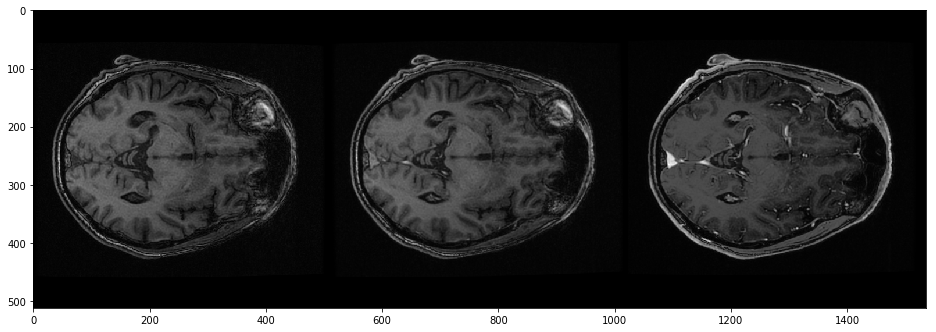

In [36]:
idx = 120
plt.figure(figsize=(16,8))
suplot.imshowtile(np.stack((x0,x1_hist_scaled,x2_hist_scaled), axis=3)[:,:,idx,:].squeeze())

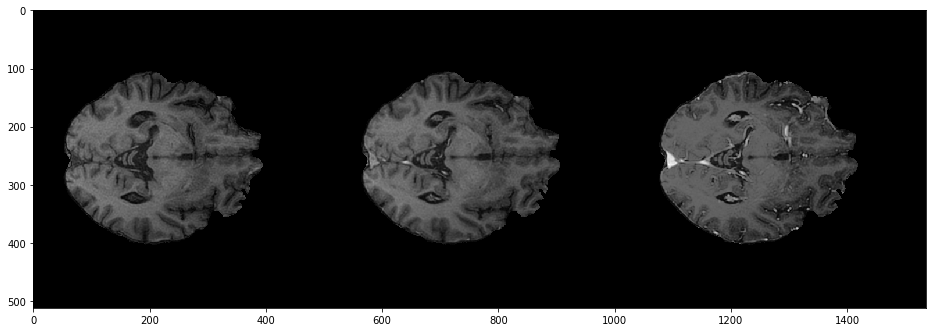

In [37]:
plt.figure(figsize=(16,8))
suplot.imshowtile(np.stack((x0b,x1b_hist_scaled,x2b_hist_scaled), axis=3)[:,:,idx,:].squeeze())

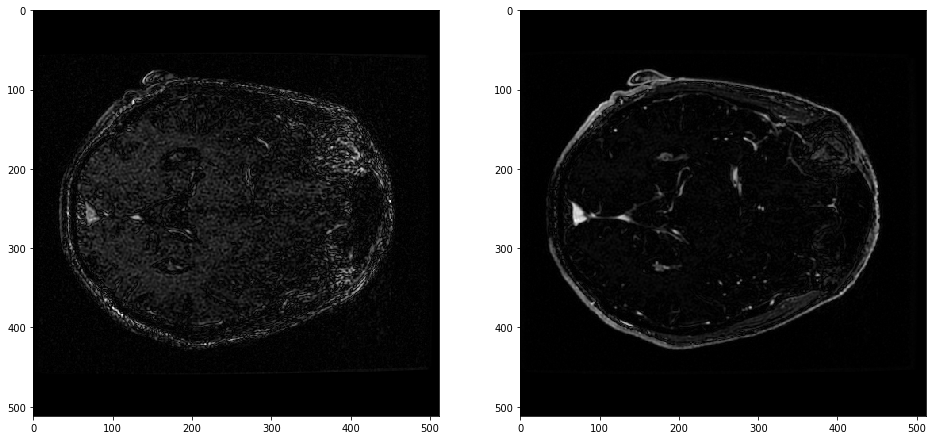

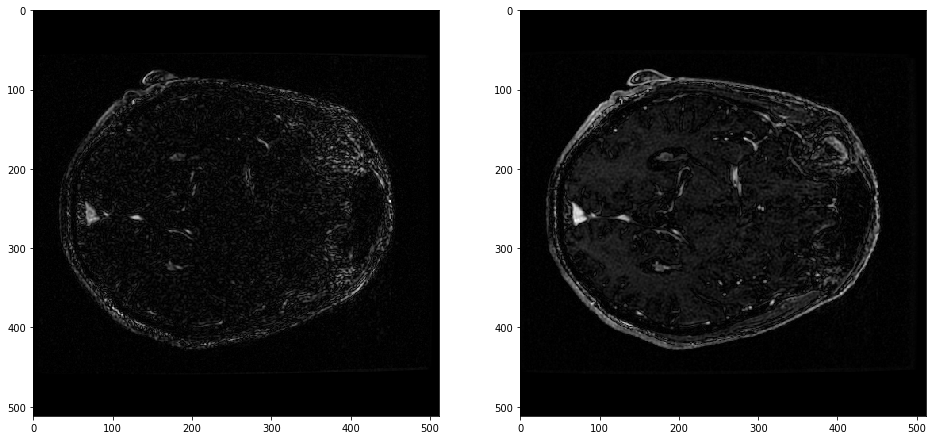

In [38]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.imshow(abs(x1_scaled[...,idx] - x0[...,idx]), cmap='gray')

plt.subplot(1,2,2)
plt.imshow(abs(x2_scaled[...,idx] - x0[...,idx]), cmap='gray')


plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.imshow(abs(x1_hist_scaled[...,idx] - x0[...,idx]), cmap='gray')

plt.subplot(1,2,2)
plt.imshow(abs(x2_hist_scaled[...,idx] - x0[...,idx]), cmap='gray')

In [1]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.imshow(abs(x1b_scaled[...,idx] - x0b[...,idx]), cmap='gray')

plt.subplot(1,2,2)
plt.imshow(abs(x2b_scaled[...,idx] - x0b[...,idx]), cmap='gray')


plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.imshow(abs(x1b_hist_scaled[...,idx] - x0b[...,idx]), cmap='gray')

plt.subplot(1,2,2)
plt.imshow(abs(x2b_hist_scaled[...,idx] - x0b[...,idx]), cmap='gray')

NameError: name 'plt' is not defined

## histogram match on brain, then put it on full image

In [35]:
idx = 90 
x1_combine = x1_hist_scaled * (x2b_mask==0) + x1b_hist_scaled
x2_combine = x2_hist_scaled * (x2b_mask==0) + x2b_hist_scaled
plt.figure(figsize=(16,8))
suplot.imshowtile(np.stack((x0[...,idx], x1_combine[...,idx], x2_combine[...,idx]), axis=2).squeeze())

plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.imshow(abs(x1_combine[...,idx] - x0[...,idx]), cmap='gray')

plt.subplot(1,2,2)
plt.imshow(abs(x2_combine[...,idx] - x0[...,idx]), cmap='gray')

plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.imshow(abs(x1_hist_scaled[...,idx] - x0[...,idx]), cmap='gray')

plt.subplot(1,2,2)
plt.imshow(abs(x2_hist_scaled[...,idx] - x0[...,idx]), cmap='gray')


NameError: name 'x2b_mask' is not defined